In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ase import io

from analyses.molecule_analysis import ase_to_rdkit_molecules, check_molecule_validity

In [2]:
models = ["z10_0.3", "z10_0.5"]
paths_to_analyse = {
    "z10_0.3": "/u/79/kurkil1/unix/work/molnet/runs/bf16-augs-rebias-adam-3e-4-z10-reverse-z/ase_0.3",
    "z10_0.5": "/u/79/kurkil1/unix/work/molnet/runs/bf16-augs-rebias-adam-3e-4-z10-reverse-z/ase_0.5",
}
# Check that all paths exist
for path in paths_to_analyse.values():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Path {path} does not exist")

Predicted, target, and full molecules:

In [3]:
pred_mols = {
    m: ase_to_rdkit_molecules(
        io.read(os.path.join(pred_path, "pred.xyz"), index=":")
    ) for m, pred_path in paths_to_analyse.items()
}
target_mols = {
    m: ase_to_rdkit_molecules(
        io.read(os.path.join(pred_path, "target.xyz"), index=":")
    ) for m, pred_path in paths_to_analyse.items()
}
full_mols = {
    m: ase_to_rdkit_molecules(
        io.read(os.path.join(pred_path, "full.xyz"), index=":")
    ) for m, pred_path in paths_to_analyse.items()
}

Check validity:

In [4]:
valid_pred_mols = {
    m: [mol for mol in mols if check_molecule_validity(mol)] for m, mols in pred_mols.items()
}
valid_target_mols = {
    m: [mol for mol in mols if check_molecule_validity(mol)] for m, mols in target_mols.items()
}
valid_full_mols = {
    m: [mol for mol in mols if check_molecule_validity(mol)] for m, mols in full_mols.items()
}

[15:36:13] Explicit valence for atom # 12 C, 4, is greater than permitted
[15:36:13] Explicit valence for atom # 4 C, 4, is greater than permitted
[15:36:13] Explicit valence for atom # 15 C, 4, is greater than permitted
[15:36:13] Explicit valence for atom # 17 C, 4, is greater than permitted
[15:36:14] Explicit valence for atom # 9 C, 4, is greater than permitted
[15:36:14] Explicit valence for atom # 14 C, 4, is greater than permitted
[15:36:14] Explicit valence for atom # 8 C, 4, is greater than permitted
[15:36:14] Explicit valence for atom # 4 C, 4, is greater than permitted
[15:36:14] Explicit valence for atom # 11 C, 4, is greater than permitted
[15:36:14] Explicit valence for atom # 6 C, 4, is greater than permitted


Save to DataFrame:

In [6]:
val_df = pd.DataFrame(columns=["model", "set", "validity"])
for model, mols in valid_pred_mols.items():
    val_fraction = len(mols) / len(pred_mols[model])
    val_df = pd.concat(
        [
            val_df,
            pd.DataFrame.from_records(
                [{"model": model, "set": "pred", "validity": val_fraction}]
            )
        ],
        ignore_index=True
    )

for model, mols in valid_target_mols.items():
    val_fraction = len(mols) / len(target_mols[model])
    val_df = pd.concat(
        [
            val_df,
            pd.DataFrame.from_records(
                [{"model": model, "set": "target", "validity": val_fraction}]
            )
        ],
        ignore_index=True
    )

for model, mols in valid_full_mols.items():
    val_fraction = len(mols) / len(full_mols[model])
    val_df = pd.concat(
        [
            val_df,
            pd.DataFrame.from_records(
                [{"model": model, "set": "full", "validity": val_fraction}]
            )
        ],
        ignore_index=True
    )

/tmp/ipykernel_1633849/3818228751.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  val_df = pd.concat(


<Axes: xlabel='model', ylabel='validity'>

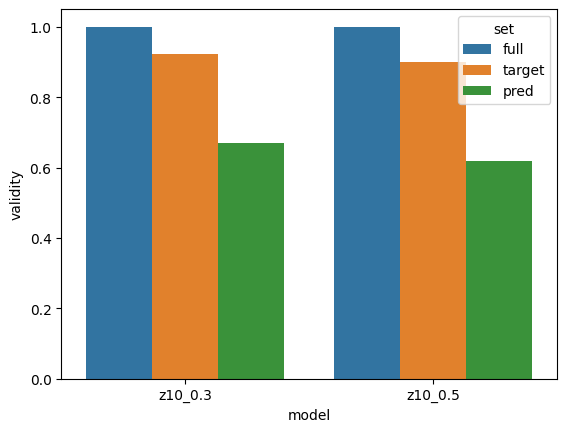

In [18]:
# plot the results as a barplot. order of the bars is "full", "pred", "target"
sns.barplot(data=val_df, x="model", y="validity", hue="set", hue_order=["full", "target", "pred"])